In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 输入图像
image_path = "./images/13.jpg"

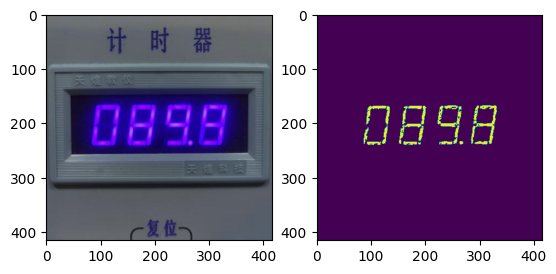

In [3]:
img_rgb = cv2.imread(image_path)

# Convert the image from BGR to HSV
img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2HSV)

# Split the HSV image into its three channels
h, s, v = cv2.split(img_hsv)

# Apply brightness enhancement to the V channel
v_enhanced = np.where(v < 250, 0, 255)

# Convert v_enhanced to the same data type as v
v_enhanced = v_enhanced.astype(v.dtype)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.subplot(1,2,2)
plt.imshow(v_enhanced)
plt.show()

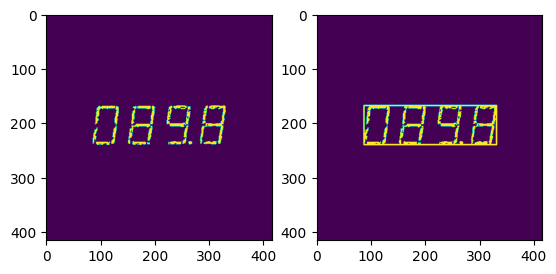

In [4]:
# 找到像素值为255的点的坐标
white_pixels = np.where(v_enhanced == 255)
x = white_pixels[1]
y = white_pixels[0]

# 找到外接矩形的左上角坐标，宽度和高度
x_min = np.min(x)
y_min = np.min(y)
x_max = np.max(x)
y_max = np.max(y)

img_with_rect = v_enhanced.copy()

# 在图像上绘制外接矩形
cv2.rectangle(img_with_rect, (x_min, y_min), (x_max, y_max), (255, 255, 255), 2)

# 显示原始图像和绘制了外接矩形的彩色图像
plt.figure()
plt.subplot(1,2,1)
plt.imshow(v_enhanced)
plt.subplot(1,2,2)
plt.imshow(img_with_rect)
plt.show()

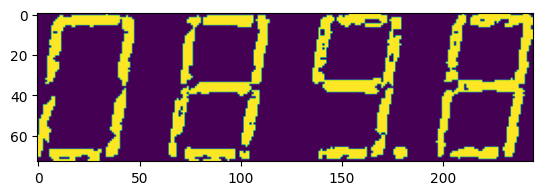

(73, 245)

In [5]:
img_roi = v_enhanced[y_min:y_max+1, x_min:x_max+1]
plt.figure()
plt.imshow(img_roi)
plt.show()
img_roi.shape

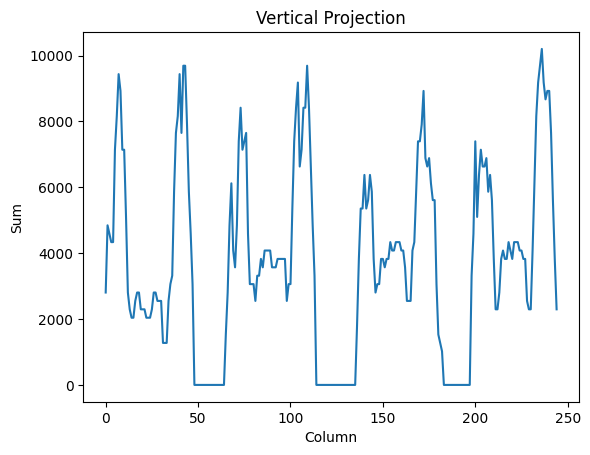

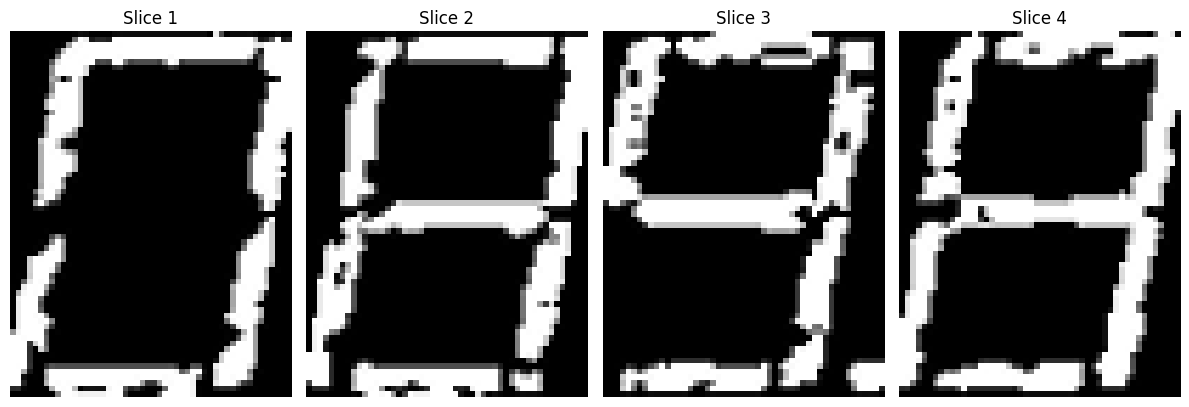

In [6]:

# 创建3x3的结构元素
kernel = np.ones((3, 3), np.uint8)

# 形态学开运算去除噪声
opened_img = cv2.morphologyEx(img_roi, cv2.MORPH_OPEN, kernel)

# 计算图像的垂直投影
vertical_projection = np.sum(opened_img, axis=0)

# 绘制垂直投影图
plt.plot(vertical_projection)
plt.title("Vertical Projection")
plt.xlabel("Column")
plt.ylabel("Sum")
plt.show()


# 找到值为0的索引
zero_indices = np.where(vertical_projection == 0)[0]

# 分离不为0的区域
non_zero_indices = np.where(vertical_projection != 0)[0]
non_zero_values = vertical_projection[non_zero_indices]

slices = []
start = non_zero_indices[0]
num_slices = 0
for idx in range(1, len(non_zero_indices)):
    if non_zero_indices[idx] - non_zero_indices[idx-1] > 1:
        # 过滤宽度较低的部分
        w = non_zero_indices[idx-1] - start
        if w < 10:
            start = non_zero_indices[idx]
            continue
        end = non_zero_indices[idx-1]
        slices.append((start, end))
        start = non_zero_indices[idx]
        num_slices += 1
slices.append((start, non_zero_indices[-1]))
num_slices += 1
# num_slices, slices
# 显示切割后的图片部分
img_slices = []
fig, axs = plt.subplots(1, num_slices, figsize=(len(slices) * 3, 6))
for i, slice_ in enumerate(slices):
    start, end = slice_
    sliced_img = img_roi[:, start:end]
    sliced_img = cv2.resize(sliced_img, (50,65), interpolation=cv2.INTER_CUBIC)
    img_slices.append(sliced_img)
    # print(sliced_img.shape)
    axs[i].imshow(sliced_img, cmap='gray')
    axs[i].set_title(f"Slice {i+1}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

    

In [7]:
# 保存图像作为训练集
# for i,img in enumerate(img_slices):
#     cv2.imwrite(f'./train/{i}.jpg', img)

In [8]:
import skimage.io as io
from skimage import data_dir
import os

In [9]:
#预先初始化分配内存，解决赋值内存空间混乱问题
train_data=[0]*10
for i in range(10):
    train_data[i]=[0 for i in range(10)]

coll=[0]*10

root_dir=os.listdir("./train")
for i in range(len(root_dir)):
    pathname=os.path.join("./train",root_dir[i])
    str=pathname+ '/*.jpg'
    coll[i]=io.ImageCollection(str)
    #统一训练数据和测试数据的大小
    for j in range(len(coll[i])):
        train_data[i][j]=cv2.resize(coll[i][j],(50,65))

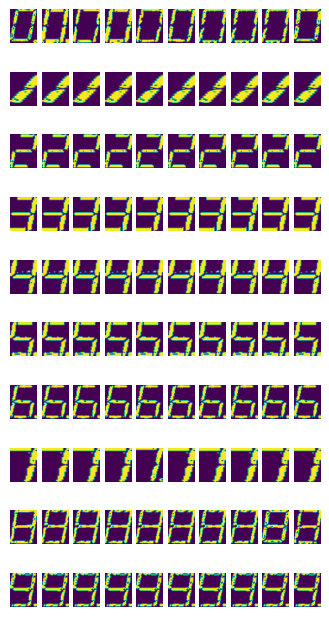

In [10]:
#显示训练数据
fig,ax=plt.subplots(10,10,figsize=(4,8))
plt.axis('off')
for i in range(10):
    for j in range(10):
        ax[i][j].imshow(np.uint8(train_data[i][j]))
        ax[i][j].set_axis_off()

In [11]:
trainData=np.zeros((100,len(train_data[0][0].ravel())))
#共有100个训练数据，每个数字10个，将每个数字图像的二维矩阵转化为一维行向量
for i in range(len(train_data)):
    for j in range(len(train_data[i])):
        trainData[i*10+j]=train_data[i][j].ravel()
trainData=np.float32(trainData)
#获得100(数据图像总数)个行向量，每个行向量有65*50=3250(像素点总数)个元素
trainData.shape

(100, 3250)

In [12]:
predictData=np.zeros((len(img_slices),len(train_data[0][0].ravel())))
for i in range(len(img_slices)):
    predictData[i]=img_slices[i].ravel()
predictData=np.float32(predictData)
predictData.shape

(4, 3250)

In [13]:
labels=np.zeros((100,1))
j=0
for i in range(len(labels)):
    if int(i/10)>j:
        j=j+1
    labels[i]=j
labels=np.float32(labels)
# labels

In [14]:
knn=cv2.ml.KNearest_create()
knn.train(trainData,cv2.ml.ROW_SAMPLE,labels)

True

In [15]:
ret,results,neighbours,dist=knn.findNearest(predictData,5)

In [16]:
print ("results: \n", results,"\n")
print ("neighbours: \n", neighbours,"\n")

results: 
 [[0.]
 [8.]
 [9.]
 [8.]] 

neighbours: 
 [[0. 0. 0. 0. 0.]
 [8. 8. 8. 8. 8.]
 [9. 9. 9. 9. 9.]
 [8. 8. 8. 8. 8.]] 



In [17]:
string=""
for i in range(len(results)):
    string=string+'%d'%(results[i][0])
string

'0898'

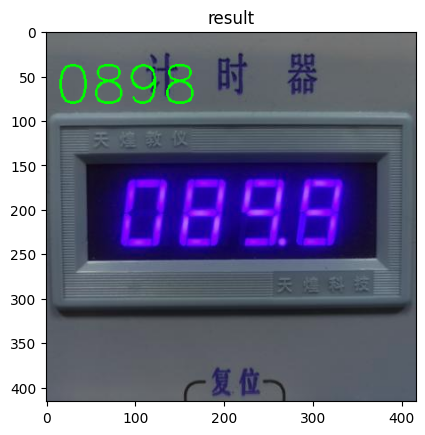

In [18]:
img_ret = img_rgb.copy()
img_ret=cv2.putText(img_ret,string,(10,80),cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),2)
plt.figure()
plt.imshow(img_ret)
plt.title("result")
plt.show()

In [19]:
# 输出图像
filename = os.path.basename(image_path)
out_path = os.path.join('./output/', filename)
cv2.imwrite(out_path, img_ret)

True